## Historic Drought Analysis

This notebook steps through an analysis of droughts in the DRB, assessing droughts using multiple different metrics including:
- Exceedance probability
- Severity
- Duration

Droughts are classified using the Standardized Streamflow Index (SSI).

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scipy.stats as scs
import spei as si


from utils.drought_plots import plot_ssi

# Directory to pywrdrb project
pywrdrb_directory = '../Pywr-DRB/'
sys.path.append(pywrdrb_directory)

from pywrdrb.pywr_drb_node_data import obs_pub_site_matches

In [2]:
def get_drought_metrics(ssi):
    """Get drought start and end dates, magnitude, severity, and duration.

    Args:
        ssi (pd.Series): Array of SSI values.  

    Returns:
        pd.DataFrame: DataFrame containing all drought metrics for each drought period.
    """
    
    drought_data = {}
    drought_counter = 0
    in_critical_drought = False
    drought_days = []

    for ind in range(len(ssi)):
        if ssi.values[ind] < 0:
            drought_days.append(ind)
            
            if ssi.values[ind] <= -1:
                in_critical_drought = True
        else:
            # Record drought info once it ends
            if in_critical_drought:
                drought_counter += 1
                drought_data[drought_counter] = {
                    'start':ssi.index[drought_days[0]],
                    'end': ssi.index[drought_days[-1]],
                    'duration': len(drought_days),
                    'magnitude': sum(ssi.values[drought_days]),
                    'severity': min(ssi.values[drought_days])
                }
            
            # Reset counters
            in_critical_drought = False
            drought_days = [] 

    drought_metrics = pd.DataFrame(drought_data).transpose()
    return drought_metrics

In [3]:
# Model generation specifications
full_date_range = ('1945-01-01', '2022-12-31')
nyc_reservoirs = ['cannonsville', 'pepacton', 'neversink']
upper_basin_reservoirs = ['prompton', 'mongaupeCombined', 'wallenpaupack', 
                          'shoholaMarsh'] 
mid_basin_reservoirs = ['fewalter', 'hopatcong', 'beltzvilleCombined',
                        'merrillCreek', 'nockamixon', 'assunpink']
lower_basin_reservoirs = ['blueMarsh', 'ontelaunee', 'stillCreek', 
                          'greenLane']

# Constants
cms_to_mgd = 22.82
fdc_quantiles = [0.0003, 0.005, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.93, 0.95, 0.97, 0.995, 0.9997]

# Historic DRBC drought events
event_types = [['emergency', '1965-07-07', '1967-03-15'],
    ['watch', '1980-10-17', '1982-04-27'], 
    ['emergency', '1981-01-15', '1982-04-27'],
    ['watch', '1982-11-13', '1983-03-27'], 
    ['watch', '1983-11-09', '1983-12-20'],
    ['watch', '1985-01-23', '1985-12-18'], 
    ['warning', '1985-02-07', '1985-12-18'], 
    ['emergency', '1985-05-13', '1985-12-18'],
    ['watch', '1989-01-16', '1989-05-12'],
    ['warning', '1989-02-05', '1989-05-12'],
    ['watch', '1991-09-13', '1992-06-17'], 
    ['warning', '1991-11-07', '1992-06-17'],
    ['watch', '1993-09-21', '1993-12-06'],
    ['watch', '1995-09-15', '1995-11-12'], 
    ['warning', '1995-10-13', '1995-11-12'],
    ['watch', '1997-10-27', '1998-01-13'],
    ['watch', '1998-12-14', '1999-02-02'],
    ['warning', '1998-12-23', '1999-02-02'],
    ['emergency', '1999-08-18', '1999-09-30'],
    ['watch', '2001-10-29', '2002-11-25'], 
    ['warning', '2001-11-04', '2002-11-25'], 
    ['emergency', '2001-12-18', '2002-11-25'],
    ['watch', '2016-11-23', '2017-01-18']]

drbc_droughts = pd.DataFrame(event_types, columns=['event_type', 'start_date', 'end_date'])
drbc_droughts.head()

,event_type,start_date,end_date
0,emergency,1965-07-07,1967-03-15
1,watch,1980-10-17,1982-04-27
2,emergency,1981-01-15,1982-04-27
3,watch,1982-11-13,1983-03-27
4,watch,1983-11-09,1983-12-20


In [4]:
# Load gage flow data
Q_hr = pd.read_csv(f'./outputs/gage_flow_obs_pub_nhmv10_NYCScaled.csv', sep = ',', index_col = 0, parse_dates = True)
Q_nhmv10 = pd.read_csv(f'{pywrdrb_directory}/input_data/gage_flow_nhmv10.csv', sep = ',', index_col = 0, parse_dates = True)
Q_nwmv21 = pd.read_csv(f'{pywrdrb_directory}/input_data/gage_flow_nwmv21.csv', sep = ',', index_col = 0, parse_dates = True)

# Get total NYC flows
Q_hr['Total NYC'] = Q_hr[nyc_reservoirs].sum(axis=1)
Q_nhmv10['Total NYC'] = Q_nhmv10[nyc_reservoirs].sum(axis=1)
Q_nwmv21['Total NYC'] = Q_nwmv21[nyc_reservoirs].sum(axis=1)


In [12]:
# Rolling sum
window = 365
consider_nodes = nyc_reservoirs + upper_basin_reservoirs +mid_basin_reservoirs+lower_basin_reservoirs
Q_hr_rolling = Q_hr.rolling(f'{window}D').sum().iloc[window:, :].dropna()
Q_nwmv21_rolling = Q_nwmv21.rolling(f'{window}D').sum().iloc[window:, :].dropna()
Q_nhmv10_rolling = Q_nhmv10.rolling(f'{window}D').sum().iloc[window:, :].dropna()

# Get SSI for each dataset
ssi_hr = pd.DataFrame(index = Q_hr_rolling.index, columns=consider_nodes)
ssi_nhmv10 = pd.DataFrame(index = Q_nhmv10_rolling.index, columns=consider_nodes)
ssi_nwmv21 = pd.DataFrame(index = Q_nwmv21_rolling.index, columns=consider_nodes)

for node in ssi_hr.columns:
    ssi_hr[node] = si.ssfi(Q_hr_rolling[node], dist = scs.gamma)
    # ssi_nhmv10[node] = si.ssfi(Q_nhmv10_rolling[node], dist = scs.gamma)
    # ssi_nwmv21[node] = si.ssfi(Q_nwmv21_rolling[node], dist = scs.gamma)

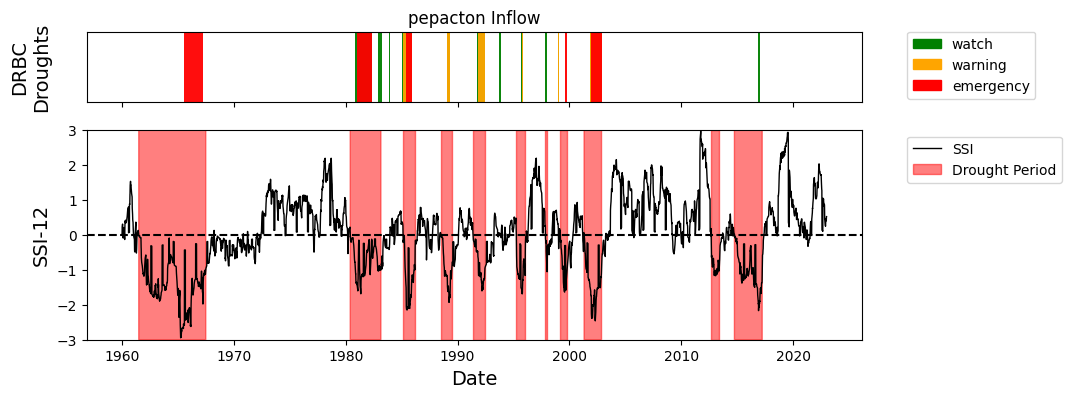

In [13]:
# Define colors for different event types
ssi = ssi_hr
event_colors = {'watch': 'green', 
                'warning': 'orange', 
                'emergency': 'red'}
plot_nodes = ['pepacton']
# plot_nodes = ['pepacton']
t_start='1960-01-01'
t_end='2022-12-31'

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), 
                               sharex=True, gridspec_kw={'height_ratios': [1, 3]})

# Iterate through the events and create colored bars
for index, row in drbc_droughts.iterrows():
    color = event_colors[row['event_type']]
    start_date = pd.to_datetime(row['start_date'])
    end_date = pd.to_datetime(row['end_date'])
    ax1.axvspan(start_date, end_date, facecolor=color, edgecolor='none', alpha=0.95)

# Adding legend for the event types
handles = [mpatches.Patch(color=color, label=event_type) for event_type, color in event_colors.items()]
ax1.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.05, 1.1))
ax1.set_ylabel('DRBC\nDroughts', fontsize=14)
ax1.set_yticks([])

# Your existing plot
plot_ssi(ssi.loc[t_start:t_end, plot_nodes[0]], ax=ax2)
ax1.set_title(f'{plot_nodes[0]} Inflow')

plt.xlabel('Date', fontsize=14)
plt.ylabel(f'SSI-{int(window/29)}', fontsize=14)
fig.align_ylabels()
ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 1.))
plt.show()


In [ ]:
plot_nodes = ['Total NYC', 'blueMarsh', 'beltzvilleCombined']
plot_nodes = nyc_reservoirs + upper_basin_reservoirs + mid_basin_reservoirs + lower_basin_reservoirs
drought_data = {}
drought_counter = 0
for node in plot_nodes:
    node_ssi = ssi[node]
    in_drought = False
    in_critical_drought = False

    drought_days = []

    for ind in range(len(ssi)):
        if node_ssi.values[ind] < 0:
            in_drought = True
            drought_days.append(ind)
            
            if node_ssi.values[ind] <= -1:
                in_critical_drought = True
        else:
            # Record drought info once it ends
            if in_critical_drought:
                drought_counter += 1
                drought_data[drought_counter] = {
                    'start':node_ssi.index[drought_days[0]],
                    'end': node_ssi.index[drought_days[-1]],
                    'duration': len(drought_days),
                    'magnitude': sum(node_ssi.values[drought_days]),
                    'severity': min(node_ssi.values[drought_days]),
                    'node': node
                }
                
            in_drought = False
            in_critical_drought = False
            drought_days = [] 

drought_metrics = pd.DataFrame(drought_data).transpose()

drought_metrics


,start,end,duration,magnitude,severity,node
1,1957-04-09,1958-07-31,479,-344.79603,-1.629328,cannonsville
2,1961-09-01,1968-03-23,2396,-3447.502115,-3.100764,cannonsville
3,1969-05-01,1972-01-21,996,-585.252061,-1.058789,cannonsville
4,1980-03-04,1983-12-12,1379,-971.618392,-1.686135,cannonsville
5,1985-02-13,1986-05-29,471,-528.190498,-2.173186,cannonsville
...,...,...,...,...,...,...
475,1991-05-30,1993-03-28,669,-1037.972811,-3.319552,greenLane
476,1995-04-10,1996-01-27,293,-237.41326,-1.4464,greenLane
477,1999-02-12,2000-08-18,554,-515.374863,-1.863999,greenLane
478,2000-09-15,2003-03-15,912,-1073.714591,-3.281387,greenLane


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


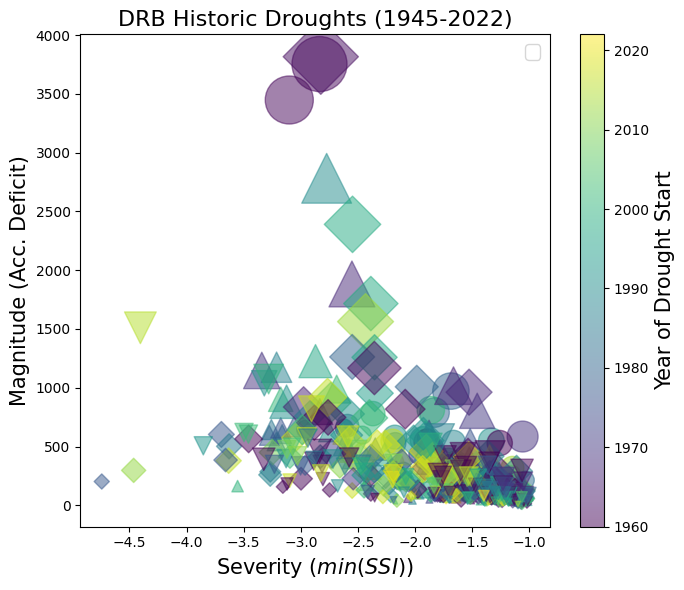

In [ ]:
## Options
marker_keys = {'NYC Reservoirs' : 'o',
               'Upper Basin Reservoirs' : "^",
               'Mid-Basin Reservoirs' : 'D',
               'Lower Basin Reservoirs': "v"}


highlight_after_1970 = False
color_by_metric = 'date'
size_by_metric = 'duration'

fig, ax = plt.subplots(figsize = (7,6))

# Loop through nodes
for node in plot_nodes:
    node_drought_metrics = drought_metrics[drought_metrics['node']==node]
    xs = node_drought_metrics['severity']
    ys = -node_drought_metrics['magnitude']

    if color_by_metric == 'duration':
        marker_colors = node_drought_metrics[color_by_metric]
    elif color_by_metric == 'date':
        marker_colors = pd.to_datetime(node_drought_metrics['start']).dt.year

    # Assign marker shape
    if node in nyc_reservoirs:
        marker_shape = marker_keys['NYC Reservoirs']
    elif node in upper_basin_reservoirs:
        marker_shape = marker_keys['Upper Basin Reservoirs']
    elif node in mid_basin_reservoirs:
        marker_shape = marker_keys['Mid-Basin Reservoirs']
    elif node in lower_basin_reservoirs:
        marker_shape = marker_keys['Lower Basin Reservoirs']

    marker_sizes = node_drought_metrics[size_by_metric].values/2 if size_by_metric else 100
    marker_sizes = list(marker_sizes)

    p = ax.scatter(xs, ys,
                s = marker_sizes,
                marker=marker_shape,
                c=marker_colors, vmin=1960, vmax=2022, 
                alpha = 0.5)


if color_by_metric:
    plt.colorbar(p).set_label(label = 'Year of Drought Start',size=15)
plt.xlabel(r'Severity ($min(SSI)$)', fontsize = 15)
plt.ylabel(r'Magnitude (Acc. Deficit)', fontsize = 15)
if len(plot_nodes) == 1:
    plt.title(f'{plot_nodes[0].capitalize()}\nHistoric Droughts (1945-2022)', fontsize = 16)
else:
    plt.title(f'DRB Historic Droughts (1945-2022)', fontsize = 16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()
